# Lab 2: Hidden Markov Models

### Dependencies

In [36]:
import numpy as np
from matplotlib import pyplot as plt
from lab2_tools import *
from lab2_proto import *
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

## Data & Model Set

In [6]:
data = np.load('lab2_data.npz', allow_pickle=True)['data']

In [7]:
data[0]

{'filename': '/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/oa.wav',
 'samplingrate': 20000,
 'gender': 'man',
 'speaker': 'bm',
 'digit': 'o',
 'repetition': 'a',
 'samples': array([-2, -1, -3, ..., 10,  8,  5], dtype=int16),
 'lmfcc': array([[  64.7657709 ,  -65.84854216,   96.90766069, ...,  -19.82632821,
           11.63249931,  159.50790488],
        [  57.72402791,  -79.93732698,  105.80893583, ...,  -11.84501965,
          109.29701349,  138.79176124],
        [  62.16944867, -121.81014369,   61.89899215, ...,   13.28252915,
         -127.7140298 , -128.75563442],
        ...,
        [ 190.29491187,   97.34488369,  175.61357289, ...,  -62.63035172,
          138.96640354,   82.95734165],
        [ 201.37123403,   80.09496653,   50.98133557, ...,  219.16711476,
           94.41131525, -100.10312668],
        [ 194.17067167,   70.85205455,   40.456538  , ...,   -3.81053312,
          143.83615904,  -42.56212766]])}

In [8]:
for x in data[0]: 
    print(x, end = '\t')  
    if x in ['digit', 'gender', 'filename', 'samplingrate', 'speaker', 'repetition']:
        print(data[0].get(x))
    else:
        print(data[0].get(x).shape)

filename	/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/oa.wav
samplingrate	20000
gender	man
speaker	bm
digit	o
repetition	a
samples	(16640,)
lmfcc	(82, 13)


### Phonetic Models

In [90]:
phoneHMMs_onespkr = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()

In [10]:
print(list(sorted(phoneHMMs_onespkr.keys())),end = '\t')

['ah', 'ao', 'ay', 'eh', 'ey', 'f', 'ih', 'iy', 'k', 'n', 'ow', 'r', 's', 'sil', 'sp', 't', 'th', 'uw', 'v', 'w', 'z']	

In [11]:
phoneHMMs_onespkr['ah'].keys()

dict_keys(['name', 'startprob', 'transmat', 'means', 'covars'])

In [12]:
for x in phoneHMMs_onespkr.keys(): 
    print(x, end = '\t')
print('\n', len(phoneHMMs_onespkr))

f	k	n	r	s	t	v	w	z	ah	ao	ay	eh	ey	ih	iy	ow	sp	th	uw	sil	
 21


In [91]:
phoneHMMs_all = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
for x in phoneHMMs_all.keys(): print(x, end = '\t')

f	k	n	r	s	t	v	w	z	ah	ao	ay	eh	ey	ih	iy	ow	sp	th	uw	sil	

In [14]:
print(phoneHMMs_all['ah'].keys())

dict_keys(['name', 'startprob', 'transmat', 'means', 'covars'])


### Pronunciation dictionary and utterance models

In [15]:
prondict = {} 
prondict['o'] = ['ow']
prondict['z'] = ['z', 'iy', 'r', 'ow']
prondict['1'] = ['w', 'ah', 'n']
prondict['2'] = ['t', 'uw']
prondict['3'] = ['th', 'r', 'iy']
prondict['4'] = ['f', 'ao', 'r']
prondict['5'] = ['f', 'ay', 'v']
prondict['6'] = ['s', 'ih', 'k', 's']
prondict['7'] = ['s', 'eh', 'v', 'ah', 'n']
prondict['8'] = ['ey', 't']
prondict['9'] = ['n', 'ay', 'n']

In [16]:
isolated = {}

In [17]:
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']

In [18]:
isolated

{'o': ['sil', 'ow', 'sil'],
 'z': ['sil', 'z', 'iy', 'r', 'ow', 'sil'],
 '1': ['sil', 'w', 'ah', 'n', 'sil'],
 '2': ['sil', 't', 'uw', 'sil'],
 '3': ['sil', 'th', 'r', 'iy', 'sil'],
 '4': ['sil', 'f', 'ao', 'r', 'sil'],
 '5': ['sil', 'f', 'ay', 'v', 'sil'],
 '6': ['sil', 's', 'ih', 'k', 's', 'sil'],
 '7': ['sil', 's', 'eh', 'v', 'ah', 'n', 'sil'],
 '8': ['sil', 'ey', 't', 'sil'],
 '9': ['sil', 'n', 'ay', 'n', 'sil']}

## Concatenating HMMs

In [81]:
def concatTwoHMMs(hmm1, hmm2):
    """ Concatenates 2 HMM models

    Args:
       hmm1, hmm2: two dictionaries with the following keys:
           name: phonetic or word symbol corresponding to the model
           startprob: M+1 array with priori probability of state
           transmat: (M+1)x(M+1) transition matrix
           means: MxD array of mean vectors
           covars: MxD array of variances

    D is the dimension of the feature vectors
    M is the number of emitting states in each HMM model (could be different for each)

    Output
       dictionary with the same keys as the input but concatenated models:
          startprob: K+1 array with priori probability of state
          transmat: (K+1)x(K+1) transition matrix
             means: KxD array of mean vectors
            covars: KxD array of variances

    K is the sum of the number of emitting states from the input models
   
    Example:
       twoHMMs = concatHMMs(phoneHMMs['sil'], phoneHMMs['ow'])

    See also: the concatenating_hmms.pdf document in the lab package
    """
    concatedHMM = {}
    #M is the number of emitting states in each HMM model (could be different for each)
    #K is the sum of the number of emitting states from the input models
    
    M1 = hmm1['means'].shape[0]
    M2 = hmm2['means'].shape[0]
    K = M1 + M2
    
    concatedHMM['name'] = hmm1['name'] + hmm2['name']
    concatedHMM['startprob'] = np.zeros((K + 1, 1))
    concatedHMM['transmat'] = np.zeros((K + 1, K + 1))
    concatedHMM['means'] = np.vstack((hmm1['means'],hmm2['means']))
    concatedHMM['covars'] = np.vstack((hmm1['covars'],hmm2['covars']))
        
    
    start1 = hmm1['startprob'].reshape(-1,1)
    start2 = hmm2['startprob'].reshape(-1,1)
    
    concatedHMM['startprob'][:hmm1['startprob'].shape[0]-1,:] = start1[:-1,:]
    concatedHMM['startprob'][hmm1['startprob'].shape[0]-1:,:] = np.dot(start1[-1,0],start2)
    trans = concatedHMM['transmat']
    trans1 = hmm1['transmat']
    trans2 = hmm2['transmat']

    trans[:trans1.shape[0]-1,:trans1.shape[1]-1] = trans1[:-1,:-1]
    temp = trans1[:-1,-1].reshape(-1,1)
    trans[:trans1.shape[0]-1,trans1.shape[1]-1:] = \
                            np.dot(temp,start2.T)
    trans[trans1.shape[0]-1:,trans1.shape[1]-1:] = trans2
    concatedHMM['transmat'] = trans    
    
    return concatedHMM

In [80]:
# this is already implemented, but based on concat2HMMs() above
def concatHMMs(hmmmodels, namelist):
    """ Concatenates HMM models in a left to right manner

    Args:
       hmmmodels: dictionary of models indexed by model name. 
       hmmmodels[name] is a dictionaries with the following keys:
           name: phonetic or word symbol corresponding to the model
           startprob: M+1 array with priori probability of state
           transmat: (M+1)x(M+1) transition matrix
           means: MxD array of mean vectors
           covars: MxD array of variances
       namelist: list of model names that we want to concatenate

    D is the dimension of the feature vectors
    M is the number of emitting states in each HMM model (could be
      different in each model)

    Output
       combinedhmm: dictionary with the same keys as the input but
                    combined models:
         startprob: K+1 array with priori probability of state
          transmat: (K+1)x(K+1) transition matrix
             means: KxD array of mean vectors
            covars: KxD array of variances

    K is the sum of the number of emitting states from the input models

    Example:
       wordHMMs['o'] = concatHMMs(phoneHMMs, ['sil', 'ow', 'sil'])
    """
    concat = hmmmodels[namelist[0]]
    for idx in range(1,len(namelist)):
        concat = concatTwoHMMs(concat, hmmmodels[namelist[idx]])
    return concat

In [21]:
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()

In [22]:
print(list(example.keys()), end='\t')

['filename', 'samplingrate', 'gender', 'speaker', 'digit', 'repetition', 'samples', 'lmfcc', 'obsloglik', 'logalpha', 'loglik', 'vloglik', 'vpath', 'logbeta', 'loggamma']	

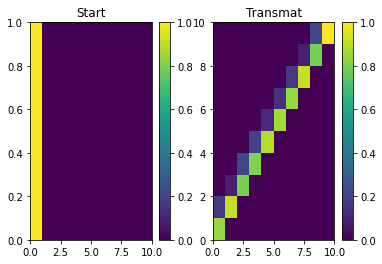

In [23]:
isolated = {}
wordHMMs = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']
    wordHMMs[digit] = concatHMMs(phoneHMMs_onespkr, isolated[digit])
_ = plt.subplot(122).set_title("Transmat")
_ = plt.pcolormesh(wordHMMs['o']['transmat'].T)
_ = plt.colorbar()
_ = plt.subplot(121).set_title("Start")
_ = plt.pcolormesh(wordHMMs['o']['startprob'].T)
_ = plt.colorbar()

## HMM Likelihood and Recognition

### Gaussian emission probabilities

Plot the log likelihood for Gaussians from HMMs models corresponding to the same digit on a test utterance of your choice. What can you say about the figure? Which Gaussian components give the high likelihood in which time steps? Why? Remember that each utterance starts and ends with silence.

In [25]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])  

In [26]:
np.allclose(obsloglik, example['obsloglik'])

True

In [39]:
example.keys()

dict_keys(['filename', 'samplingrate', 'gender', 'speaker', 'digit', 'repetition', 'samples', 'lmfcc', 'obsloglik', 'logalpha', 'loglik', 'vloglik', 'vpath', 'logbeta', 'loggamma'])

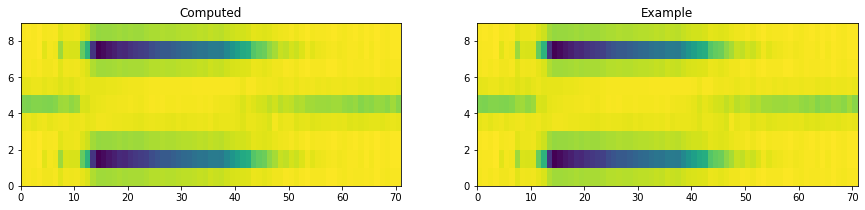

In [34]:
plt.rcParams['figure.figsize'] = [15, 3]
plt.subplot(121).set_title("Computed")
plt.pcolormesh(obsloglik.T)
plt.subplot(122).set_title("Example")
plt.pcolormesh(example['obsloglik'].T)

In [50]:
def forward(log_emlik, log_startprob, log_transmat):
    """Forward (alpha) probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: log transition probability from state i to j

    Output:
        forward_prob: NxM array of forward log probabilities for each of the M states in the model
    """
    alpha = np.zeros(log_emlik.shape)
    alpha[0][:] = log_startprob.T + log_emlik[0]

    for n in range(1,len(alpha)):
        for i in range(alpha.shape[1]):
            alpha[n, i] = logsumexp(alpha[n - 1] + log_transmat[:,i]) + log_emlik[n,i]
    return alpha

In [51]:
log_startprob = np.log(wordHMMs['o']['startprob'][:-1])
log_transmat = np.log(wordHMMs['o']['transmat'][:-1,:-1])
alpha = forward(example['obsloglik'], log_startprob, log_transmat)

In [53]:
np.allclose(alpha, example["logalpha"])

True

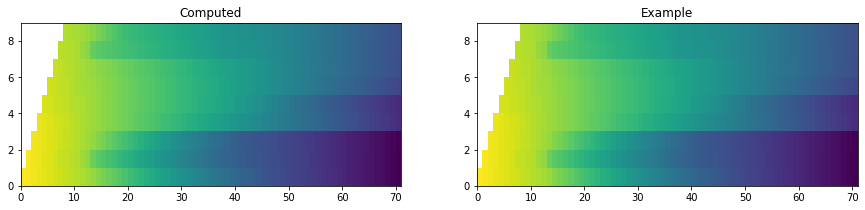

In [54]:
plt.rcParams['figure.figsize'] = [15, 3]
plt.subplot(121).set_title("Computed")
plt.pcolormesh(alpha.T)
plt.subplot(122).set_title("Example")
plt.pcolormesh(example['logalpha'].T)

In [61]:
hmm_loglik = logsumexp(alpha[-1])

In [62]:
np.allclose(hmm_loglik, example["loglik"])

True

In [82]:
isolated = {}
wordHMMs_all = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']
    wordHMMs_all[digit] = concatHMMs(phoneHMMs_all, isolated[digit])

In [86]:
%%time
performance = np.zeros((44,11))
no_utterance = 0
for utterance in data:
    no_word = 0 
    for word in wordHMMs_all:
        obsloglik = log_multivariate_normal_density_diag(utterance['lmfcc'], wordHMMs_all[word]['means'], wordHMMs_all[word]['covars'])  
        log_startprob = np.log(wordHMMs_all[word]['startprob'][:-1])
        log_transmat = np.log(wordHMMs_all[word]['transmat'][:-1,:-1])
        alpha = forward(obsloglik, log_startprob, log_transmat) 
        hmm_loglik = logsumexp(alpha[-1]) 
        performance[no_utterance, no_word] = hmm_loglik
        #print(int(hmm_loglik), end = "\t")
        #print(no_utterance,no_word ,end = '\t')
        no_word += 1
    #print()
    no_utterance += 1

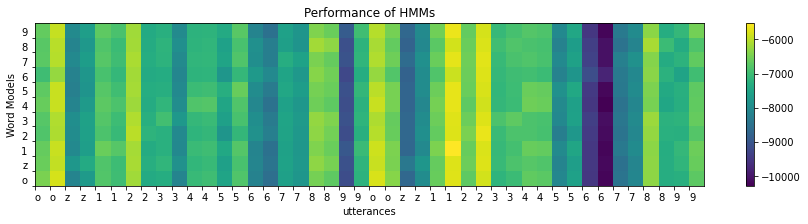

In [88]:
all_words = []
for x in wordHMMs_all: all_words.append(x)
all_utterance = []   
for x in data: all_utterance.append(x['digit'])
_ = plt.rcParams['figure.figsize'] = [15, 3]
_ = plt.subplot(111).set_title("Performance of HMMs")
_ = plt.pcolormesh(performance.T)
_ = plt.colorbar()
_ = plt.ylabel('Word Models')
_ = plt.xlabel('utterances')
_ = plt.yticks(range(len(all_words)), all_words, verticalalignment = 'bottom')
_ = plt.xticks(range(len(all_utterance)), all_utterance, horizontalalignment = 'left')

In [89]:
performance_max = np.copy(performance.T)
predictions_alpha = (performance_max == performance_max.max(axis = 0,keepdims = 1))
match = 0
for i in range(len(all_words)):
    for j in range(len(all_utterance)):
        if(predictions_alpha[i,j] == True and all_words[i] == all_utterance[j]):
            match += 1
print("Accuracy :", 100*float(match)/predictions_alpha.shape[1])

Accuracy : 97.72727272727273


In [92]:
isolated = {}
wordHMMs_all = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']
    wordHMMs_all[digit] = concatHMMs(phoneHMMs_onespkr, isolated[digit])

performance = np.zeros((44,11))

no_utterance = 0
for utterance in data:
    no_word = 0 
    for word in wordHMMs_all:
        obsloglik = log_multivariate_normal_density_diag(utterance['lmfcc'], wordHMMs_all[word]['means'], wordHMMs_all[word]['covars'])  
        log_startprob = np.log(wordHMMs_all[word]['startprob'][:-1])
        log_transmat = np.log(wordHMMs_all[word]['transmat'][:-1,:-1])
        alpha = forward(obsloglik, log_startprob, log_transmat) 
        hmm_loglik = logsumexp(alpha[-1]) 
        performance[no_utterance, no_word] = hmm_loglik
        #print(int(hmm_loglik), end = "\t")
        #print(no_utterance,no_word ,end = '\t')
        no_word += 1
    #print()
    no_utterance += 1

all_words = []
for x in wordHMMs_all: all_words.append(x)
all_utterance = []   
for x in data: all_utterance.append(x['digit'])

performance_max = np.copy(performance.T)
predictions_alpha = (performance_max == performance_max.max(axis = 0,keepdims = 1))
match = 0
for i in range(len(all_words)):
    for j in range(len(all_utterance)):
        if(predictions_alpha[i,j] == True and all_words[i] == all_utterance[j]):
            match += 1
print("Accuracy :", 100*float(match)/predictions_alpha.shape[1])

Accuracy : 77.27272727272727


In [93]:
def viterbi(log_emlik, log_startprob, log_transmat, forceFinalState=True):
    """Viterbi path.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j
        forceFinalState: if True, start backtracking from the final state in
                  the model, instead of the best state at the last time step

    Output:
        viterbi_loglik: log likelihood of the best path
        viterbi_path: best path
    """
    
    N = log_emlik.shape[0]
    M = log_emlik.shape[1]
    
    viterbi_path = np.empty((N), dtype=np.int)
    viterbi_loglik = 0
    V = np.zeros((N,M))
    B = np.zeros((N,M))
    
    for j in range(M):
        V[0, j] = log_startprob[j] + log_emlik[0,j]
        
    for n in range(1,N):
        for j in range(M):
            V[n, j] = np.max(V[n-1,:] + log_transmat[:,j]) + log_emlik[n,j]
            B[n, j] = np.argmax(V[n-1,:] + log_transmat[:,j])
    
    viterbi_path[-1] = np.argmax(V[-1, :])
    viterbi_loglik = V[N-1, viterbi_path[-1]]
    
    for n in range(0,N-1):
        viterbi_path[n] += np.max(V[n-1,:])
    
    for n in reversed(range(N-1)):
        for j in range(M):
            viterbi_path[n] = B[n+1, viterbi_path[n+1]]
            
    return (viterbi_loglik, viterbi_path)

In [96]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])  
log_startprob = np.log(wordHMMs['o']['startprob'][:-1])
log_transmat = np.log(wordHMMs['o']['transmat'][:-1,:-1])
alpha = forward(obsloglik, log_startprob, log_transmat) 

In [97]:
vloglik, vpath = viterbi(obsloglik, log_startprob, log_transmat)

In [98]:
np.allclose(vloglik, example['vloglik'])

True

In [99]:
np.allclose(vpath, example['vpath'])

True

[1 2 2 2 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 8 9 9 9 9 9 9 9 9 9 9]


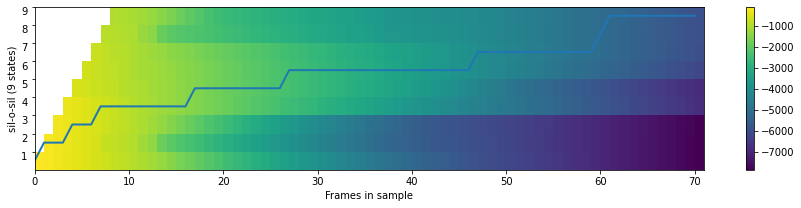

In [100]:
_ = plt.figure(figsize=(15,3))
_ = plt.pcolormesh(np.ma.masked_array(alpha.T))
_ = plt.plot(vpath+0.5, linewidth = 2)
_ = plt.colorbar()
_ = plt.yticks(range(1,10), verticalalignment='top')
_ = plt.xlabel('Frames in sample')
_ = plt.ylabel('sil-o-sil (9 states)')
print(vpath+1)

Can you explain the reason why the path looks this way?

In [104]:
isolated = {}
wordHMMs_all = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']
    wordHMMs_all[digit] = concatHMMs(phoneHMMs_all, isolated[digit])

performance = np.zeros((44,11))

In [105]:
%%time
warnings.filterwarnings('ignore')
performance = np.zeros((44,11))
#for words in wordHMMs: print(words, end = "\t")
#print()
no_utterance = 0
for utterance in data:
    no_word = 0 
    for word in wordHMMs_all:
        obsloglik = log_multivariate_normal_density_diag(utterance['lmfcc'], wordHMMs_all[word]['means'], wordHMMs_all[word]['covars'])  
        log_startprob = np.log(wordHMMs_all[word]['startprob'][:-1])
        log_transmat = np.log(wordHMMs_all[word]['transmat'][:-1,:-1])
        vloglik, vpath = viterbi(obsloglik, log_startprob, log_transmat)
        performance[no_utterance, no_word] = vloglik
        no_word += 1
    no_utterance += 1

CPU times: user 9.28 s, sys: 75.3 ms, total: 9.35 s
Wall time: 10 s


In [106]:
all_words = []
for x in wordHMMs_all: all_words.append(x)
all_utterance = []   
for x in data: all_utterance.append(x['digit'])
performance_max = np.copy(performance.T)
predictions_viterbi = (performance_max == performance_max.max(axis = 0,keepdims = 1))
match = 0
for i in range(len(all_words)):
    for j in range(len(all_utterance)):
        if(predictions_viterbi[i,j] == True and all_words[i] == all_utterance[j]):
            match += 1
print("Accuracy :", 100*float(match)/predictions_viterbi.shape[1])

Accuracy : 100.0


In [107]:
def backward(log_emlik, log_startprob, log_transmat):
    """Backward (beta) probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j

    Output:
        backward_prob: NxM array of backward log probabilities for each of the M states in the model
    """

    N, M = log_emlik.shape
    beta = np.empty((N,M))
    beta[-1,:] = 0
    for n in reversed(range(N-1)):
        for i in range(M):
            beta[n,i] = logsumexp(log_transmat[i,:] + log_emlik[n+1,:] + beta[n+1,:])
    return beta

In [108]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])  
log_startprob = np.log(wordHMMs['o']['startprob'][:-1])
log_transmat = np.log(wordHMMs['o']['transmat'][:-1,:-1])
beta = backward(obsloglik, log_startprob, log_transmat)

In [109]:
np.allclose(beta, example['logbeta'])

True

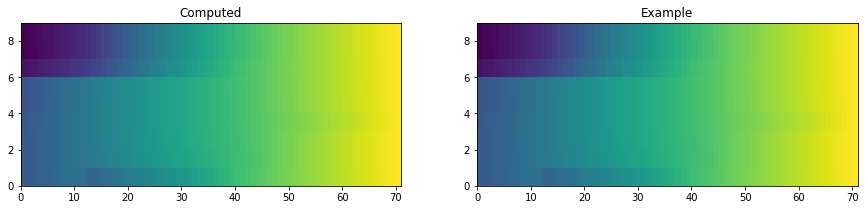

In [110]:
plt.rcParams['figure.figsize'] = [15, 3]
plt.subplot(121).set_title("Computed")
plt.pcolormesh(beta.T)
plt.subplot(122).set_title("Example")
plt.pcolormesh(example['logbeta'].T)

In [111]:
def statePosteriors(log_alpha, log_beta):
    """State posterior (gamma) probabilities in log domain.

    Args:
        log_alpha: NxM array of log forward (alpha) probabilities
        log_beta: NxM array of log backward (beta) probabilities
    where N is the number of frames, and M the number of states

    Output:
        log_gamma: NxM array of gamma probabilities for each of the M states in the model
    """
    N = len(log_alpha)
    log_gamma = log_alpha + log_beta - logsumexp(log_alpha[N - 1])
    return log_gamma

In [120]:
gamma = statePosteriors(alpha, beta)

In [122]:
np.allclose(gamma, example['loggamma'])

True

In [123]:
np.sum(np.exp(gamma), axis = 1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

Sum of posteriors along time axis:
 [ 1.34597458  2.09555994  3.55849998  9.73752276 10.12040999 20.5329264
 12.9968938   1.20869929  9.40351326]

Sum of all posteriors: 71.00
Length of observ seq: 71



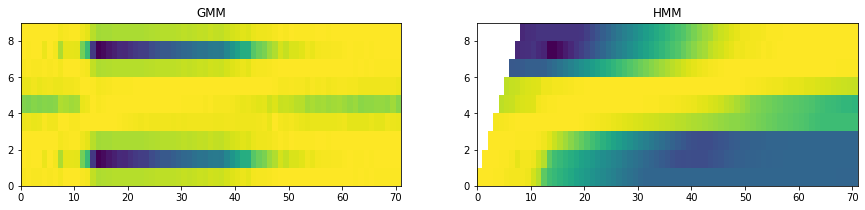

In [126]:
gamma_gmm = obsloglik - logsumexp(obsloglik, axis=1).reshape(-1, 1)

plt.rcParams['figure.figsize'] = [15, 3]
plt.subplot(121).set_title("GMM")
plt.pcolormesh(gamma_gmm.T)
plt.subplot(122).set_title("HMM")
plt.pcolormesh(gamma.T)


print('Sum of posteriors along time axis:\n', np.exp(logsumexp(gamma)))
print()

print('Sum of all posteriors: {:.2f}'.format(np.exp(logsumexp(logsumexp(gamma)))))
print('Length of observ seq: {}'.format(len(obsloglik)))
print()

In [127]:
def updateMeanAndVar(X, log_gamma, varianceFloor=5.0):
    """ Update Gaussian parameters with diagonal covariance

    Args:
         X: NxD array of feature vectors
         log_gamma: NxM state posterior probabilities in log domain
         varianceFloor: minimum allowed variance scalar
    were N is the lenght of the observation sequence, D is the
    dimensionality of the feature vectors and M is the number of
    states in the model

    Outputs:
         means: MxD mean vectors for each state
         covars: MxD covariance (variance) vectors for each state
    """

    gamma = np.exp(log_gamma)
    means = np.zeros((log_gamma.shape[1], X.shape[1]))
    covars = np.zeros(means.shape)

    for i in range(means.shape[0]):
        gamma_sum = np.sum(gamma[:,i])
        means[i] = np.sum(gamma[:,i].reshape(-1, 1) * X, axis = 0) / gamma_sum
        covars[i] = np.sum(gamma[:,i].reshape(-1, 1) * (X - means[i])**2, axis = 0) / gamma_sum
        covars[i, covars[i] < varianceFloor] = varianceFloor
    return means, covars


In [128]:
def retrain_emission_dist(utterance, wordHMM, maxiter=20, threshold=1.0):
    loglik = []

    for i in range(maxiter):
        # E-step
        obsloglik = log_multivariate_normal_density_diag(utterance['lmfcc'], wordHMM['means'], wordHMM['covars'])
        logalpha, loglik_ = forward(obsloglik, np.log(wordHMM['startprob']), np.log(wordHMM['transmat']))
        logbeta = backward(obsloglik, np.log(wordHMM['startprob']), np.log(wordHMM['transmat']))[0]
        loggamma = statePosteriors(logalpha, logbeta)

        # check termination (here to avoid running forward() two times per iteration)
        if i > 0 and abs(loglik_ - loglik[-1]) < threshold:
            break
        loglik.append(loglik_)

        # M-step
        wordHMM['means'], wordHMM['covars'] = updateMeanAndVar(utterance['lmfcc'], loggamma)

    return loglik

In [129]:
plt.figure()
utterance = data[10]

for word, wordHMM in wordHMMs_all.items():
    wordHMM = wordHMM.copy()
    loglik = retrain_emission_dist(utterance, wordHMM)

    plt.plot(loglik, label='digit {}'.format(word))
    plt.xlabel('# iterations')
    plt.ylabel('log-likelihood')
    plt.title("Learning curve (only emission distributions, utterance of '{}')".format(utterance['digit']))
plt.legend()

ValueError: operands could not be broadcast together with shapes (1,10) (9,) 

<Figure size 1080x216 with 0 Axes>